Import important parameter

In [1]:
inputsize = 31**2
e = 0.08

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 16.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 16*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,16*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <1000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
error=10e-11
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

sqrtinputsize = int(np.sqrt(inputsize))
sqrtmidputsize = int(sqrtinputsize/2)
midputsize = int(sqrtmidputsize**2)
sqrtoutputsize = int(sqrtmidputsize/2)
outputsize = int(sqrtoutputsize**2)

h = 1/(sqrtinputsize-1)
H = 1/(sqrtoutputsize-1)
A0 = Poisson(inputsize)
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A1 = gallery.nonlinearPoisson((n,n), kx, ky)
n = inputsize
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
Media = a(X,Y)
R1 = Restriction(inputsize)
R2 = Restriction(midputsize)
R  = np.matmul(R2, R1)
P = 16*np.transpose(R)

GMM on fine grid

In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, w, error)

Residual = 11.276176196042773
Interation = 1
Residual = 5.2329731190703495
Interation = 2
Residual = 3.531255258480714
Interation = 3
Residual = 2.4695194365867357
Interation = 4
Residual = 1.7434973533922509
Interation = 5
Residual = 1.2388141345545207
Interation = 6
Residual = 0.8857746452701033
Interation = 7
Residual = 0.6374588814706066
Interation = 8
Residual = 0.4618002083881954
Interation = 9
Residual = 0.3367865907600254
Interation = 10
Residual = 0.24724987024027992
Interation = 11
Residual = 0.18269641637383066
Interation = 12
Residual = 0.13583705524184655
Interation = 13
Residual = 0.10158682696296295
Interation = 14
Residual = 0.0763817072684803
Interation = 15
Residual = 0.057710397733307044
Interation = 16
Residual = 0.04379275860588206
Interation = 17
Residual = 0.033358543866113505
Interation = 18
Residual = 0.02549485157034774
Interation = 19
Residual = 0.019540680070946243
Interation = 20
Residual = 0.01501378944793889
Interation = 21
Residual = 0.011559736135121967

Error GMM on fine grid

In [6]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
GMMU = GMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = GMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
1.9725603932102487
L2 norm: 
0.12910264549061612
H1 norm: 
1.4961734639894797
Energy norm: 
0.1531955531417837
L2 norm: 
0.25820529098123224
H1 norm: 
0.16406045876032002


Solution

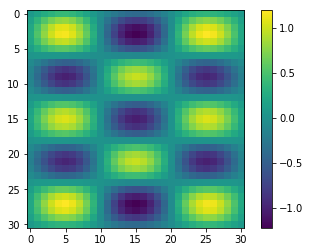

In [7]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

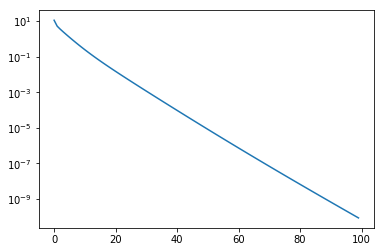

In [8]:
plt.semilogy(GMM_Res)

Radius

In [9]:
GMM_Radius = rho(inputsize,A1.to_full(),16*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.8309271720785314


Global DMM optimization

In [10]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, 
                                                           learning_rate = 1e-6,accept_radius =
                                                           GMM_Radius*10,step_length =  1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.8320278854369864
L = 0.03
rho = 0.8320222325828474
L = 0.04
rho = 0.8320156456968737
L = 0.05
rho = 0.8320081835283653
L = 0.060000000000000005
rho = 0.8319999024849374
L = 0.07
rho = 0.8319908566572392
L = 0.08
rho = 0.831981097856648
L = 0.09
rho = 0.8319706756629641
L = 0.09999999999999999
rho = 0.8319596374796666
L = 0.10999999999999999
rho = 0.8319480285947398
L = 0.11999999999999998
rho = 0.8319358922454451
L = 0.12999999999999998
rho = 0.8319232696857201
L = 0.13999999999999999
rho = 0.8319102002551357
L = 0.15
rho = 0.8318967214485515
L = 0.16
rho = 0.831882868985778
L = 0.17
rho = 0.8318686768806994
L = 0.18000000000000002
rho = 0.8318541775094263
L = 0.19000000000000003
rho = 0.8318394016771404
L = 0.20000000000000004
rho = 0.8318243786833787
L = 0.21000000000000005
rho = 0.8318091363855623
L = 0.22000000000000006
rho = 0.8317937012606342
L = 0.23000000000000007
rho = 0.8317780984647111
L = 0.24000000000000007
rho = 0.8317623518906873
L 

the 27 steps
rho = 0.830914401677284
the 28 steps
rho = 0.8309142967061994
the 29 steps
rho = 0.830914191735855
the 30 steps
rho = 0.8309140867662508
the 31 steps
rho = 0.8309139817973865
the 32 steps
rho = 0.8309138768292622
the 33 steps
rho = 0.8309137718618776
the 34 steps
rho = 0.8309136668952327
the 35 steps
rho = 0.8309135619293273
the 36 steps
rho = 0.8309134569641613
the 37 steps
rho = 0.8309133519997346
the 38 steps
rho = 0.830913247036047
the 39 steps
rho = 0.8309131420730983
the 40 steps
rho = 0.8309130371108885
the 41 steps
rho = 0.8309129321494175
the 42 steps
rho = 0.8309128271886851
the 43 steps
rho = 0.8309127222286912
the 44 steps
rho = 0.8309126172694357
the 45 steps
rho = 0.8309125123109183
the 46 steps
rho = 0.8309124073531391
the 47 steps
rho = 0.8309123023960978
the 48 steps
rho = 0.8309121974397945
the 49 steps
rho = 0.8309120924842288
the 50 steps
rho = 0.8309119875294007
the 51 steps
rho = 0.8309118825753101
the 52 steps
rho = 0.8309117776219568
the 53 steps
rh

the 168 steps
rho = 0.8308996080026613
the 169 steps
rho = 0.830899503134702
the 170 steps
rho = 0.8308993982674651
the 171 steps
rho = 0.8308992934009505
the 172 steps
rho = 0.8308991885351581
the 173 steps
rho = 0.8308990836700878
the 174 steps
rho = 0.8308989788057394
the 175 steps
rho = 0.8308988739421128
the 176 steps
rho = 0.830898769079208
the 177 steps
rho = 0.8308986642170247
the 178 steps
rho = 0.830898559355563
the 179 steps
rho = 0.8308984544948225
the 180 steps
rho = 0.8308983496348032
the 181 steps
rho = 0.830898244775505
the 182 steps
rho = 0.8308981399169278
the 183 steps
rho = 0.8308980350590714
the 184 steps
rho = 0.8308979302019358
the 185 steps
rho = 0.8308978253455207
the 186 steps
rho = 0.830897720489826
the 187 steps
rho = 0.8308976156348518
the 188 steps
rho = 0.8308975107805976
the 189 steps
rho = 0.8308974059270636
the 190 steps
rho = 0.8308973010742496
the 191 steps
rho = 0.8308971962221554
the 192 steps
rho = 0.8308970913707808
the 193 steps
rho = 0.83089698

the 308 steps
rho = 0.8308849334624233
the 309 steps
rho = 0.8308848286944064
the 310 steps
rho = 0.8308847239270947
the 311 steps
rho = 0.8308846191604881
the 312 steps
rho = 0.8308845143945864
the 313 steps
rho = 0.8308844096293898
the 314 steps
rho = 0.8308843048648978
the 315 steps
rho = 0.8308842001011106
the 316 steps
rho = 0.8308840953380279
the 317 steps
rho = 0.8308839905756497
the 318 steps
rho = 0.8308838858139757
the 319 steps
rho = 0.8308837810530058
the 320 steps
rho = 0.83088367629274
the 321 steps
rho = 0.8308835715331782
the 322 steps
rho = 0.8308834667743201
the 323 steps
rho = 0.8308833620161657
the 324 steps
rho = 0.8308832572587149
the 325 steps
rho = 0.8308831525019675
the 326 steps
rho = 0.8308830477459236
the 327 steps
rho = 0.8308829429905827
the 328 steps
rho = 0.830882838235945
the 329 steps
rho = 0.8308827334820102
the 330 steps
rho = 0.8308826287287784
the 331 steps
rho = 0.8308825239762492
the 332 steps
rho = 0.8308824192244225
the 333 steps
rho = 0.830882

the 448 steps
rho = 0.8308702727484606
the 449 steps
rho = 0.8308701680780142
the 450 steps
rho = 0.8308700634082562
the 451 steps
rho = 0.8308699587391868
the 452 steps
rho = 0.8308698540708056
the 453 steps
rho = 0.8308697494031128
the 454 steps
rho = 0.8308696447361079
the 455 steps
rho = 0.8308695400697911
the 456 steps
rho = 0.8308694354041621
the 457 steps
rho = 0.8308693307392209
the 458 steps
rho = 0.8308692260749673
the 459 steps
rho = 0.8308691214114012
the 460 steps
rho = 0.8308690167485225
the 461 steps
rho = 0.8308689120863312
the 462 steps
rho = 0.8308688074248269
the 463 steps
rho = 0.8308687027640097
the 464 steps
rho = 0.8308685981038794
the 465 steps
rho = 0.8308684934444359
the 466 steps
rho = 0.8308683887856791
the 467 steps
rho = 0.8308682841276089
the 468 steps
rho = 0.8308681794702253
the 469 steps
rho = 0.8308680748135278
the 470 steps
rho = 0.8308679701575166
the 471 steps
rho = 0.8308678655021915
the 472 steps
rho = 0.8308677608475524
the 473 steps
rho = 0.830

the 588 steps
rho = 0.8308556255335098
the 589 steps
rho = 0.8308555209583306
the 590 steps
rho = 0.8308554163838238
the 591 steps
rho = 0.8308553118099892
the 592 steps
rho = 0.8308552072368268
the 593 steps
rho = 0.8308551026643364
the 594 steps
rho = 0.8308549980925178
the 595 steps
rho = 0.8308548935213711
the 596 steps
rho = 0.830854788950896
the 597 steps
rho = 0.8308546843810926
the 598 steps
rho = 0.8308545798119605
the 599 steps
rho = 0.8308544752434998
the 600 steps
rho = 0.8308543706757103
the 601 steps
rho = 0.8308542661085919
the 602 steps
rho = 0.8308541615421445
the 603 steps
rho = 0.8308540569763679
the 604 steps
rho = 0.8308539524112621
the 605 steps
rho = 0.830853847846827
the 606 steps
rho = 0.8308537432830625
the 607 steps
rho = 0.8308536387199683
the 608 steps
rho = 0.8308535341575444
the 609 steps
rho = 0.8308534295957908
the 610 steps
rho = 0.8308533250347072
the 611 steps
rho = 0.8308532204742936
the 612 steps
rho = 0.8308531159145498
the 613 steps
rho = 0.83085

the 728 steps
rho = 0.8308409914997631
the 729 steps
rho = 0.8308408870176145
the 730 steps
rho = 0.8308407825361225
the 731 steps
rho = 0.8308406780552869
the 732 steps
rho = 0.8308405735751079
the 733 steps
rho = 0.830840469095585
the 734 steps
rho = 0.8308403646167183
the 735 steps
rho = 0.8308402601385078
the 736 steps
rho = 0.830840155660953
the 737 steps
rho = 0.8308400511840542
the 738 steps
rho = 0.8308399467078112
the 739 steps
rho = 0.8308398422322237
the 740 steps
rho = 0.8308397377572918
the 741 steps
rho = 0.8308396332830152
the 742 steps
rho = 0.8308395288093939
the 743 steps
rho = 0.8308394243364279
the 744 steps
rho = 0.8308393198641167
the 745 steps
rho = 0.8308392153924606
the 746 steps
rho = 0.8308391109214595
the 747 steps
rho = 0.830839006451113
the 748 steps
rho = 0.8308389019814211
the 749 steps
rho = 0.8308387975123837
the 750 steps
rho = 0.8308386930440007
the 751 steps
rho = 0.830838588576272
the 752 steps
rho = 0.8308384841091976
the 753 steps
rho = 0.8308383

the 868 steps
rho = 0.8308263703385715
the 869 steps
rho = 0.830826265947281
the 870 steps
rho = 0.8308261615566319
the 871 steps
rho = 0.8308260571666239
the 872 steps
rho = 0.8308259527772571
the 873 steps
rho = 0.8308258483885314
the 874 steps
rho = 0.8308257440004464
the 875 steps
rho = 0.8308256396130022
the 876 steps
rho = 0.8308255352261987
the 877 steps
rho = 0.8308254308400358
the 878 steps
rho = 0.8308253264545135
the 879 steps
rho = 0.8308252220696313
the 880 steps
rho = 0.8308251176853895
the 881 steps
rho = 0.8308250133017878
the 882 steps
rho = 0.8308249089188261
the 883 steps
rho = 0.8308248045365044
the 884 steps
rho = 0.8308247001548226
the 885 steps
rho = 0.8308245957737803
the 886 steps
rho = 0.8308244913933777
the 887 steps
rho = 0.8308243870136147
the 888 steps
rho = 0.8308242826344909
the 889 steps
rho = 0.8308241782560065
the 890 steps
rho = 0.8308240738781613
the 891 steps
rho = 0.830823969500955
the 892 steps
rho = 0.8308238651243879
the 893 steps
rho = 0.83082

Global DMM on fine grid

In [11]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, error)

Residual = 11.275741559979336
Interation = 1
Residual = 5.2310235702288805
Interation = 2
Residual = 3.529554691208699
Interation = 3
Residual = 2.4679326214539428
Interation = 4
Residual = 1.7420768787559637
Interation = 5
Residual = 1.2375943658836506
Interation = 6
Residual = 0.8847569634521214
Interation = 7
Residual = 0.636625815525934
Interation = 8
Residual = 0.46112673277301974
Interation = 9
Residual = 0.33624647758803333
Interation = 10
Residual = 0.246818796282591
Interation = 11
Residual = 0.18235323185894015
Interation = 12
Residual = 0.13556407122950473
Interation = 13
Residual = 0.10136961469190295
Interation = 14
Residual = 0.07620868797370589
Interation = 15
Residual = 0.0575723751183537
Interation = 16
Residual = 0.043682471737056305
Interation = 17
Residual = 0.0332702750097319
Interation = 18
Residual = 0.02542409931965106
Interation = 19
Residual = 0.019483895574723298
Interation = 20
Residual = 0.014968167939176304
Interation = 21
Residual = 0.01152305424957177
In

Error DMM on fine grid

In [12]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
DMMU = DMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = DMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
1.9725603932102123
L2 norm: 
0.12910264549061304
H1 norm: 
1.4961734639894548
Energy norm: 
0.15319555314178088
L2 norm: 
0.2582052909812261
H1 norm: 
0.1640604587603173


Solution

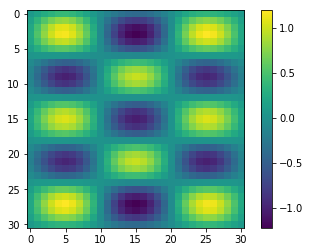

In [13]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

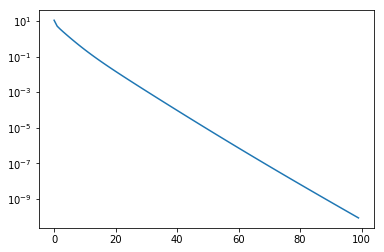

In [14]:
plt.semilogy(DMM_Res)

Radius

In [15]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.8308127005012483


Rrestriction matrix after optimization

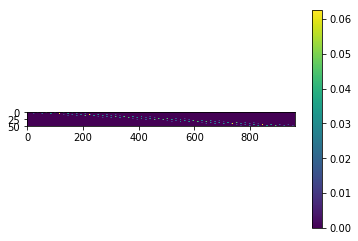

In [16]:
plt.imshow(Rnew)
plt.colorbar()

Rrestriction matrix (log(abs()) after optimization

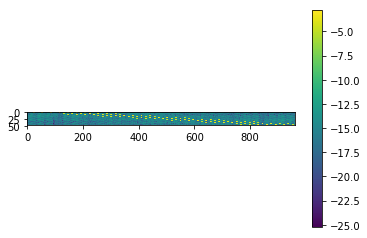

In [17]:
plt.imshow(np.log(np.abs(Rnew)))
plt.colorbar()

Basis after optimization

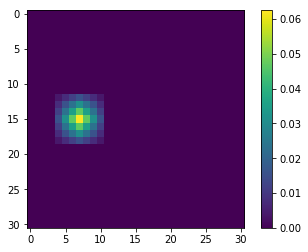

In [18]:
basis1 = Rnew[int(0.45*outputsize)][:]
basis1 = basis1.reshape([sqrtinputsize,sqrtinputsize])
plt.imshow(basis1)
plt.colorbar()

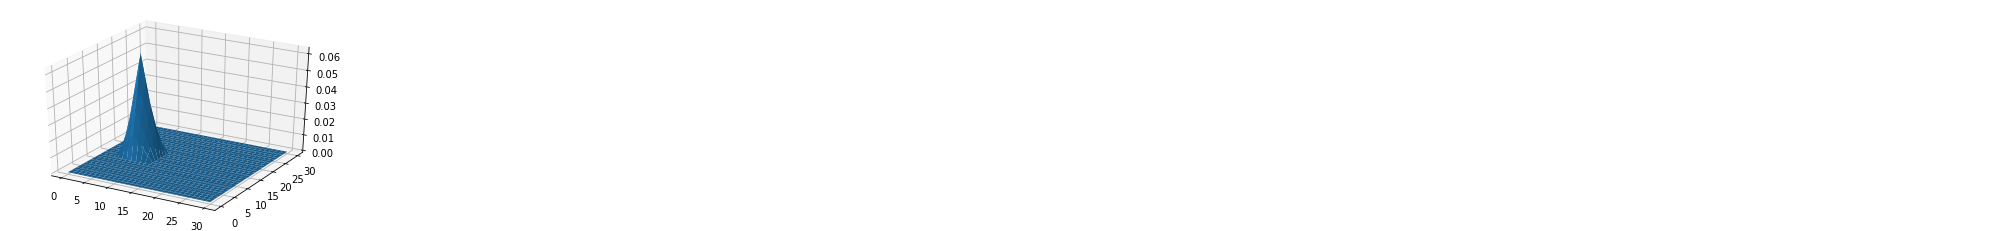

In [19]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
size=basis1.shape
Y=np.arange(0,size[0],1)     
X=np.arange(0,size[1],1)

X,Y=np.meshgrid(X,Y)    
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,basis1)
plt.show()

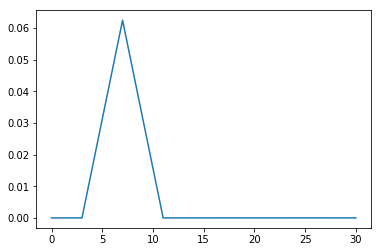

In [20]:
plt.plot(basis1[:][int(sqrtinputsize/2)])

Basis after optimization (log(abs()))

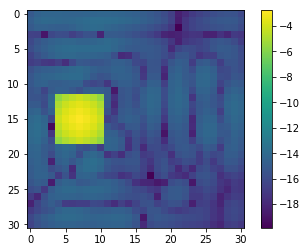

In [21]:
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()

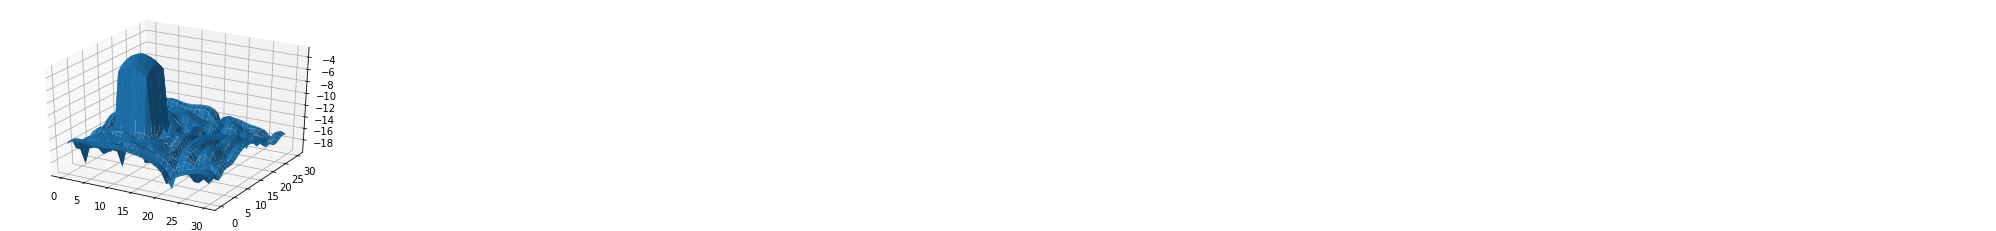

In [22]:
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(np.abs(basis1)))
plt.show()

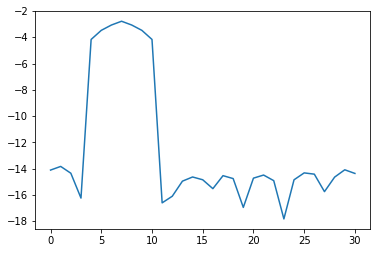

In [23]:
plt.plot(np.log(np.abs(basis1[:][int(sqrtinputsize/2)])))

FEM use basis from global DMM

Energy norm: 
5.667743314030181
L2 norm: 
0.20009666326623865
H1 norm: 
4.093953179753369
Energy norm: 
0.4401756595373116
L2 norm: 
0.4001933265324773
H1 norm: 
0.44891575273810047


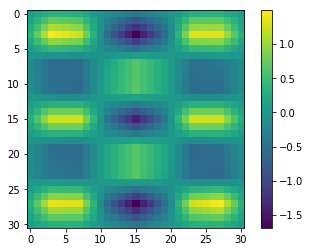

In [24]:

Anew = np.zeros([outputsize,outputsize])
[X1, Y1] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
[X2, Y2] = np.meshgrid(np.linspace(0, 1, sqrtoutputsize),np.linspace(0, 1, sqrtoutputsize))
A = a(X1,Y1)
for i in range(outputsize):
    for j in range(outputsize):
        basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
        basisj = Rnew[j][:].reshape([sqrtinputsize,sqrtinputsize])
        gxbasisi = np.gradient(basisi,axis=0)/h
        gybasisi = np.gradient(basisi,axis=1)/h
        gxbasisj = np.gradient(basisj,axis=0)/h
        gybasisj = np.gradient(basisj,axis=1)/h
        Anew[i][j]=(np.sum(A*gxbasisi*gxbasisj)+np.sum(A*gybasisi*gybasisj))*(H**2)
        
Fnew = np.zeros([outputsize,1])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    F = rightf(X1,Y1)
    Fnew[i]=np.sum(F*basisi)*(H**2)
    
UnewCoarse = np.linalg.solve(Anew,Fnew)
Unew = np.zeros([sqrtinputsize,sqrtinputsize])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    Unew = Unew + UnewCoarse[i]*basisi

plt.imshow(Unew)
plt.colorbar()

UREAL = u_real(X1,Y1).reshape(sqrtinputsize,sqrtinputsize)
deltaU = Unew - UREAL
A = a(X1,Y1)

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),A)*(h**2)))
l2norm = np.sqrt((np.sum(UREAL**2))*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))
print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))



print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum(deltaU**2))*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

In [25]:
import os
os.system("say 'The program has finished, Please check the results'")

0